In [66]:
import pandas as pd
import numpy as np
import json
import re
import os
from argparse import Namespace
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
args = Namespace(
    rawCSV = "roi_data.csv",
    contextual_data = "context.json",
    modifiedCSV = "roi_data_new.csv",
    dataParameterCoverage = 50,  # Rule of thumb to allow few categorical values
    includeColumns =[],
    lambdas = {}
)
def encodeFunc(pairs,encodeDict):
    return lambda x: encodeDict["{}_{}".format(x[pairs[0]],x[pairs[1]])] if "{}_{}".format(x[pairs[0]],x[pairs[1]]) in encodeDict else 0
args.encodeUtils = encodeFunc

## Modified the csv and separate the contextual_data

In [ ]:
badLines = []
with open(args.rawCSV,"r") as f:
    lines = f.readlines()
    modifiedLines = []
    dicts = []
    for i in tqdm(range(len(lines)), desc='Load CSV Lines'):
        line = lines[i]
        if not i:
            modifiedLines.append(line.replace("contextual_data,",""))
        else:
            findit = re.findall("\"\{.*\}\"",line)
            if len(findit):
                dictstr = findit[0]
                dicts.append(json.loads(dictstr))
                newline = line.replace(dictstr,"").replace(",,",",")
                modifiedLines.append(newline)
            else:
                badLines.append(i)
                continue
with open(args.contextual_data, 'w') as f:
    json.dump(dicts, f)

with open(args.modifiedCSV, 'w') as f:
    f.writelines(modifiedLines)

for i in badLines:
    print(lines[i])

In [87]:
df = pd.read_csv(args.modifiedCSV)

### Show Categorical value counts to Data Coverage.
### Skip columns that have too many categorical values. The code doesn't take whether column values are continuous type or not into consideation

### Conversion ROI is a continuous variable which is what we calibrate to, so it would be dropped as well.

In [195]:
contDfs = df.select_dtypes(include="float64")
contDfs['exchange_vcr'].unique()

array([0.])

In [88]:
contDfs = df.select_dtypes(include="float64")
colsHandled = contDfs.columns
contDfs = contDfs[[ _ for _ in contDfs.columns if contDfs[_].unique().shape[0]>1]]
contDfs.corr()

,exchange_viewability_rate,exchange_ctr,conversion_roi
exchange_viewability_rate,1.000000,0.098844,-0.010651
exchange_ctr,0.098844,1.000000,0.000233
conversion_roi,-0.010651,0.000233,1.000000


### Add continuous columns

In [89]:
args.includeColumns = args.includeColumns+list(contDfs.columns)

In [90]:
def sortFunc(e):
    return len(e[1])
nameList = [(name,list(df[name].unique())) for name in df.columns if name not in colsHandled ]
nameList.sort(reverse=True, key=sortFunc)

In [91]:
totalParams = 0
skipNames = [_[0] for _ in nameList]  
for i in range(len(nameList)):
    if (totalParams+len(nameList[-1-i][1]))>df.shape[0]/args.dataParameterCoverage:
        break
    totalParams += len(nameList[-1-i][1])
    del skipNames[-1]
print( "Skip Columns:",skipNames,"\nTotal Model Parameters ={}, Data Coverage={:0.1f}".format(totalParams, df.shape[0]/totalParams))
print("Raw Parameters Count Before Condensing {}".format(sum([df[_].unique().shape[0] for _ in df.columns 
            if _ not in ['mm_auction_id', 'imp_timestamp', 'overlapped_brain_pixel_selections']+ args.includeColumns])))

Skip Columns: ['mm_auction_id', 'imp_timestamp', 'overlapped_brain_pixel_selections', 'site_id', 'base_domain'] 
Total Model Parameters =16538, Data Coverage=83.6
Raw Parameters Count Before Condensing 67559


### Create Flat presentation of the value tables, where the row dimension corresponds to the largest raw categorical value counts
### Naive way already have about 68K parameters

In [92]:
def printSummary(namelist,skipNames):
    dfTemp = None
    modifiedList = [ _ for _ in nameList if _[0] not in skipNames]
    for i in tqdm(range(len(modifiedList[0][1])), desc='Generate rows'):
        result = {}
        for val in modifiedList:
            result[val[0]] = [val[1][i] if i<len(val[1]) else None]
        if dfTemp is None:
            dfTemp = pd.DataFrame.from_dict(result)
        else:
            dfTemp = pd.concat([dfTemp, pd.DataFrame.from_dict(result)])
    return dfTemp
dfTemp=printSummary(nameList,skipNames)
dfTemp.iloc[1,:] #To take a look at typical value set

Generate rows:   0%|          | 0/9492 [00:00<?, ?it/s]

publisher_id                                   157076
hashed_app_id                                       0
device_model           ma_DesktopMake:mo_DesktopModel
browser_version            br_ChromeMobile:ve_107.0.0
deal_id                                             0
category_id                                 432963713
os_version                       os_Android:ve_13.0.0
dma_id                                          80029
device_manufacturer                    ma_DesktopMake
browser_language_id                             28261
region_id                                       70016
exchange_id                                         3
isp_id                                          30014
browser                               br_ChromeMobile
impression_date                            2022-11-23
os                                         os_Windows
browser_id                                      80212
size                                         19661050
day_of_week                 

### Adding derived fields from 'imp_timestamp','overlapped_brain_pixel_selections'

In [93]:
df["Date"] = df.apply(lambda x:pd.to_datetime(x["imp_timestamp"].split(" ")[0]),axis=1) ##Only for Testing/Training Data usage

### Add overlapped brain pixel components into selections. They are dummy Pixel and recency/frequency values
### Recency data looks very fishy and probably need to drop it or add log transformation to clean it

In [94]:
df["pixel"]=df.apply(lambda x: x["overlapped_brain_pixel_selections"].split(":")[1] if x["overlapped_brain_pixel_selections"]!="nulls" else -999 , axis=1)
df["recency"] = df.apply(lambda x: float(x["overlapped_brain_pixel_selections"].split(":")[2]) if x["overlapped_brain_pixel_selections"]!="nulls" else -999 , axis=1)
df["frequency"] = df.apply(lambda x: float(x["overlapped_brain_pixel_selections"].split(":")[3]) if x["overlapped_brain_pixel_selections"]!="nulls" else -999 , axis=1)
[df["pixel"].unique().shape[0],df["frequency"].unique().shape[0],df["recency"].unique().shape[0],df["pixel"].unique()]

[2, 94, 106174, array([-999, '1535320'], dtype=object)]

In [95]:
df["qualifiedPixel"] = df.apply(lambda x: False if x["overlapped_brain_pixel_selections"]=="nulls" else True, axis=1) #Should use as dummy selection for recency and frequency

In [96]:
df[df.apply(lambda x: x["qualifiedPixel"], axis=1)][["recency","frequency"]].describe()

,recency,frequency
count,2.566840e+05,256684.000000
mean,1.479701e+06,2.561426
std,6.151304e+06,4.128997
min,0.000000e+00,1.000000
25%,9.969000e+03,1.000000
50%,3.462850e+04,1.000000
75%,7.651225e+04,2.000000
max,2.783807e+07,114.000000


In [97]:
args.includeColumns = args.includeColumns+["qualifiedPixel","recency","frequency"]

### Address cross effects if possible so collapse some columns into one column
### Idea is to use cross tab to see whether two columns can be combined into 1

In [98]:
for pairs in ([['device_model','device_manufacturer'],["os_version","os"],["browser_version","browser"],["browser_version","browser_language_id"]]):
    conf_matrix = pd.crosstab(df[pairs[0]],df[pairs[1]])
    data2d = conf_matrix.to_numpy()
    print("{} Dim= {} {} Dim={} Possible Cross {} Observed Cross {}".format(pairs[0],conf_matrix.shape[0],pairs[1],conf_matrix.shape[1],conf_matrix.shape[0]*conf_matrix.shape[1],data2d[data2d>0].shape[0]))

device_model Dim= 984 device_manufacturer Dim=98 Possible Cross 96432 Observed Cross 984
os_version Dim= 242 os Dim=8 Possible Cross 1936 Observed Cross 242
browser_version Dim= 625 browser Dim=31 Possible Cross 19375 Observed Cross 625
browser_version Dim= 625 browser_language_id Dim=56 Possible Cross 35000 Observed Cross 1664


### We can now conclude that device_manufacturer can be dropped since there is a direct map from device_model(os_version) to them. However, lanuguage can't be dropped

In [99]:
args.includeColumns = args.includeColumns+["device_model","os_version"]
skipNames += ['device_manufacturer',"os"]

In [100]:
args.includeColumns = args.includeColumns+["browser_version"]
skipNames += ['browser']

### Any cross relation between other fields so we can combine more?

### common idea is different device would like to host different browser, so it is not surprised they are linked. Samething should apply to app vs device. ALso out of curiosity, added browser version to hashed app and there is lots gaps because of null values

In [197]:
pd.crosstab(df['device_model'],df['device_manufacturer'])

device_manufacturer,ma_AT&T,ma_Acer,ma_Alcatel,ma_Amazon,ma_Apple,ma_Asus,ma_Axia,ma_BLU,ma_BarnesandNoble,ma_Beista,...,ma_Verizon,ma_Vivo,ma_Vsmart,ma_Wiko,ma_Winnovo,ma_Xiaomi,ma_ZTE,ma_Zonko,ma_eTalk,ma_itel
device_model,,,,,,,,,,,,,,,,,,,,,
ma_AT&T:mo_Calypso,79,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ma_AT&T:mo_EmblemRadiant,56,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ma_AT&T:mo_Maestro,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ma_AT&T:mo_MaestroPlus,87,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ma_AT&T:mo_Primetime,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ma_ZTE:mo_Zpad,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,21,0,0,0
ma_ZTE:mo_nubiaRedMagic5G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
ma_Zonko:mo_K118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [101]:
threshold = 50
for pairs in ([['browser_version','device_model'],
               ["browser_version","browser_language_id"],
               ["hashed_app_id",'device_model'],
               ["hashed_app_id","browser_version"]]):
    conf_matrix = pd.crosstab(df[pairs[0]],df[pairs[1]])
    data2d = conf_matrix.to_numpy()
    print("{} Dim= {} \t{} Dim={} \tPossible Cross {} \t Observed Cross>0 {} Observed Cross>{:0.0f} {} Ratio={:0.5f} \nObserved Cross>{} {} Ratio={:0.5f} Total Count {}\n".format(pairs[0],conf_matrix.shape[0],pairs[1],conf_matrix.shape[1],
        conf_matrix.shape[0]*conf_matrix.shape[1],data2d[data2d>0].shape[0],df.shape[0]/(conf_matrix.shape[0]*conf_matrix.shape[1]),
        data2d[data2d>(df.shape[0]/(conf_matrix.shape[0]*conf_matrix.shape[1]))].shape[0],
        data2d[data2d>(df.shape[0]/(conf_matrix.shape[0]*conf_matrix.shape[1]))].shape[0]/(conf_matrix.shape[0]*conf_matrix.shape[1]),
        threshold,data2d[data2d>threshold].shape[0],
        data2d[data2d>threshold].shape[0]/(conf_matrix.shape[0]*conf_matrix.shape[1]),np.sum(data2d[data2d>threshold])))

browser_version Dim= 625 	device_model Dim=849 	Possible Cross 530625 	 Observed Cross>0 4971 Observed Cross>3 2266 Ratio=0.00427 
Observed Cross>50 322 Ratio=0.00061 Total Count 912964

browser_version Dim= 625 	browser_language_id Dim=56 	Possible Cross 35000 	 Observed Cross>0 1664 Observed Cross>40 357 Ratio=0.01020 
Observed Cross>50 325 Ratio=0.00929 Total Count 926099

hashed_app_id Dim= 3872 	device_model Dim=984 	Possible Cross 3810048 	 Observed Cross>0 16635 Observed Cross>0 16635 Ratio=0.00437 
Observed Cross>50 698 Ratio=0.00018 Total Count 1307654

hashed_app_id Dim= 762 	browser_version Dim=625 	Possible Cross 476250 	 Observed Cross>0 2739 Observed Cross>3 1050 Ratio=0.00220 
Observed Cross>50 197 Ratio=0.00041 Total Count 925139



In [102]:
skipNames += ['browser_version',"hashed_app_id"]
threshold = 50
for pairs in ([['browser_version','device_model'],
               ["hashed_app_id",'device_model']]):
    conf_matrix = pd.crosstab(df[pairs[0]],df[pairs[1]])
    data2d = conf_matrix.to_numpy()
    encodeDict={}
    codeVal = 1
    for i in range(data2d.shape[0]):
        for j in range(data2d.shape[1]):
            if data2d[i,j]>threshold:
                encodeDict["{}_{}".format(conf_matrix.index[i],conf_matrix.columns[j])]=codeVal
                codeVal += 1
    args.lambdas["{}_{}".format(pairs[0],pairs[1])] = args.encodeUtils(pairs, encodeDict)
    args.includeColumns = args.includeColumns+["{}_{}".format(pairs[0],pairs[1])]
    df[args.includeColumns[-1]] = df.apply(args.lambdas["{}_{}".format(pairs[0],pairs[1])], axis = 1)

### Add the rest ids

In [103]:
# Per media math suggestion
skipNames += ['browser_id',"os_id"]

In [104]:
for name in dfTemp.columns:
    if (not name in skipNames) and (not name in args.includeColumns):
        print(name,dfTemp[name].unique().shape[0])

publisher_id 9492
deal_id 337
category_id 328
dma_id 213
browser_language_id 67
region_id 54
exchange_id 48
isp_id 44
impression_date 16
size 10
day_of_week 8
creative_id 8
id_vintage 6
device_id 6
device_type 6
day_part 5
conn_speed 4
fold_position 4
channel_type 4
num_device_ids 4
country_id 3
cross_device_flag 3
viewability_autotag 2


### Publisher have big size add it to skip columns and see how to reduce it

In [105]:
skipNames += ["publisher_id"]

In [106]:
args.includeColumns = args.includeColumns + [name for name in dfTemp.columns if (not name in skipNames) and (not name in args.includeColumns)]

In [107]:
args.includeColumns

['exchange_viewability_rate',
 'exchange_ctr',
 'conversion_roi',
 'qualifiedPixel',
 'recency',
 'frequency',
 'device_model',
 'os_version',
 'browser_version',
 'browser_version_device_model',
 'hashed_app_id_device_model',
 'deal_id',
 'category_id',
 'dma_id',
 'browser_language_id',
 'region_id',
 'exchange_id',
 'isp_id',
 'impression_date',
 'size',
 'day_of_week',
 'creative_id',
 'id_vintage',
 'device_id',
 'device_type',
 'day_part',
 'conn_speed',
 'fold_position',
 'channel_type',
 'num_device_ids',
 'country_id',
 'cross_device_flag',
 'viewability_autotag']

### Handle Domain, Site and Published_id

base domain unique count:16120, site id unique count:34900, publisher id unique count:9492


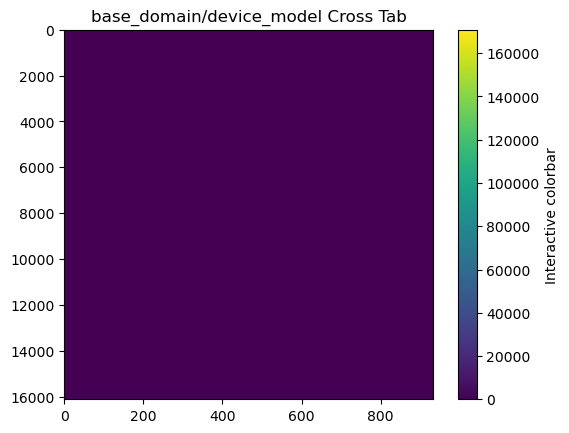

base_domain Dim= 16114 	device_model Dim=934 	Possible Cross 15050476 	 Observed Cross>0 66727 Observed Cross>0 66727 Ratio=0.00443 
Observed Cross>50 2061 Ratio=0.00014 Total Count 969255



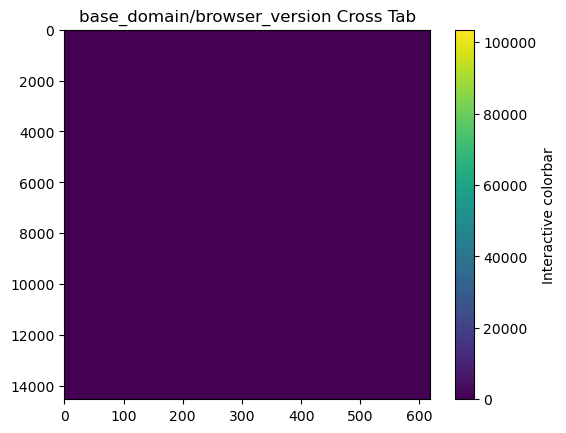

base_domain Dim= 14523 	browser_version Dim=619 	Possible Cross 8989737 	 Observed Cross>0 73786 Observed Cross>0 73786 Ratio=0.00821 
Observed Cross>50 1725 Ratio=0.00019 Total Count 681007



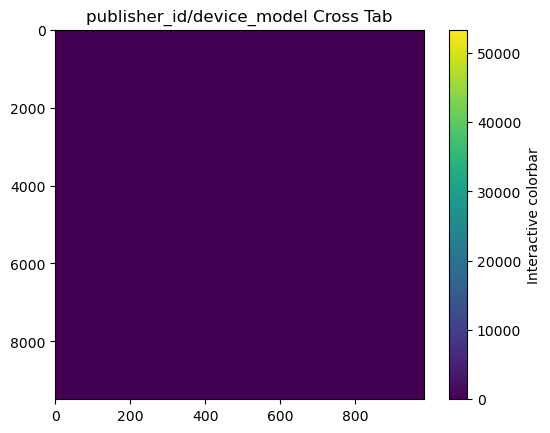

publisher_id Dim= 9486 	device_model Dim=984 	Possible Cross 9334224 	 Observed Cross>0 63829 Observed Cross>0 63829 Ratio=0.00684 
Observed Cross>50 2179 Ratio=0.00023 Total Count 1171887



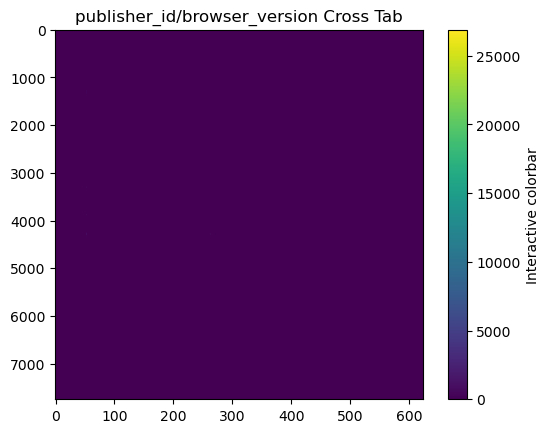

publisher_id Dim= 7746 	browser_version Dim=625 	Possible Cross 4841250 	 Observed Cross>0 53336 Observed Cross>0 53336 Ratio=0.01102 
Observed Cross>50 1989 Ratio=0.00041 Total Count 731249



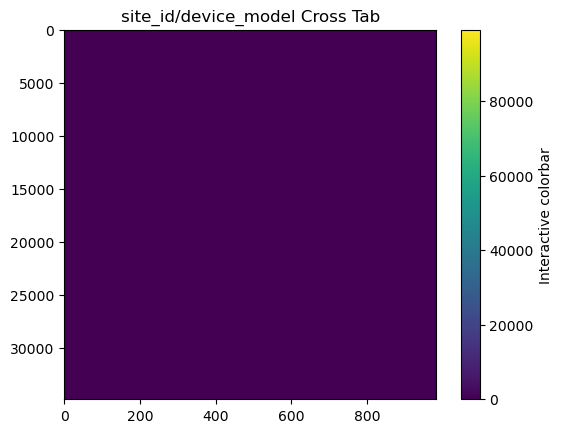

site_id Dim= 34886 	device_model Dim=984 	Possible Cross 34327824 	 Observed Cross>0 98328 Observed Cross>0 98328 Ratio=0.00286 
Observed Cross>50 2443 Ratio=0.00007 Total Count 1079914



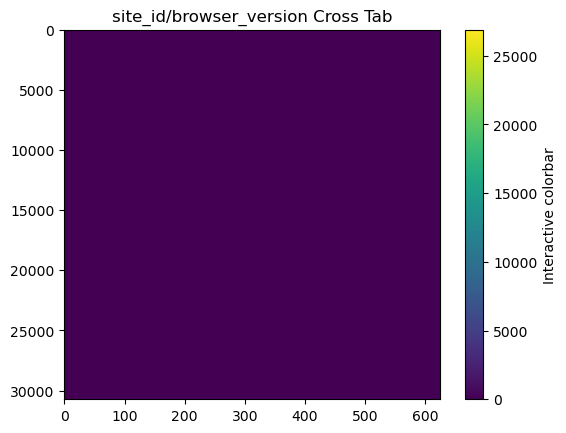

site_id Dim= 30729 	browser_version Dim=625 	Possible Cross 19205625 	 Observed Cross>0 103432 Observed Cross>0 103432 Ratio=0.00539 
Observed Cross>50 1950 Ratio=0.00010 Total Count 628234



In [108]:
threshold = 50
print("base domain unique count:{}, site id unique count:{}, publisher id unique count:{}".format(df["base_domain"].unique().shape[0],
        df["site_id"].unique().shape[0],df["publisher_id"].unique().shape[0]))
for pairs in ([["base_domain",'device_model'],["base_domain","browser_version"],
               ["publisher_id",'device_model'],["publisher_id","browser_version"],
            ["site_id",'device_model'],["site_id","browser_version"]]):
    conf_matrix = pd.crosstab(df[pairs[0]],df[pairs[1]])
    data2d = conf_matrix.to_numpy()
    fig, ax = plt.subplots()
    im = ax.imshow(data2d,aspect='{:0.3f}'.format(data2d.shape[1]/data2d.shape[0]))
    ax.set_title('{}/{} Cross Tab'.format(pairs[0],pairs[1]))
    fig.colorbar(im, ax=ax, label='Interactive colorbar')
    plt.show()
    print("{} Dim= {} \t{} Dim={} \tPossible Cross {} \t Observed Cross>0 {} Observed Cross>{:0.0f} {} Ratio={:0.5f} \nObserved Cross>{} {} Ratio={:0.5f} Total Count {}\n".format(pairs[0],conf_matrix.shape[0],pairs[1],conf_matrix.shape[1],
        conf_matrix.shape[0]*conf_matrix.shape[1],data2d[data2d>0].shape[0],df.shape[0]/(conf_matrix.shape[0]*conf_matrix.shape[1]),
        data2d[data2d>(df.shape[0]/(conf_matrix.shape[0]*conf_matrix.shape[1]))].shape[0],
        data2d[data2d>(df.shape[0]/(conf_matrix.shape[0]*conf_matrix.shape[1]))].shape[0]/(conf_matrix.shape[0]*conf_matrix.shape[1]),
        threshold,data2d[data2d>threshold].shape[0],
        data2d[data2d>threshold].shape[0]/(conf_matrix.shape[0]*conf_matrix.shape[1]),np.sum(data2d[data2d>threshold])))

### Proposal One. We would use cross tab entries to encode site,domain and publisher

In [109]:
args.includeColumnsProposal1 = args.includeColumns.copy()

In [110]:
threshold = 50
for pairs in ([["base_domain",'device_model'],
               ["site_id",'device_model'],
               ["publisher_id",'device_model']]):
    conf_matrix = pd.crosstab(df[pairs[0]],df[pairs[1]])
    data2d = conf_matrix.to_numpy()
    encodeDict={}
    codeVal = 1
    for i in range(data2d.shape[0]):
        for j in range(data2d.shape[1]):
            if data2d[i,j]>threshold:
                encodeDict["{}_{}".format(conf_matrix.index[i],conf_matrix.columns[j])]=codeVal
                codeVal += 1
    args.lambdas["{}_{}".format(pairs[0],pairs[1])] = args.encodeUtils(pairs, encodeDict)
    args.includeColumnsProposal1 = args.includeColumnsProposal1+["{}_{}".format(pairs[0],pairs[1])]
    df[args.includeColumnsProposal1[-1]] = df.apply(args.lambdas["{}_{}".format(pairs[0],pairs[1])], axis = 1)

In [116]:
sum([df[_].unique().shape[0] for _ in args.includeColumnsProposal1 if (_ not in contDfs.columns) and (_ not in ["recency","frequency"])])+len(contDfs.columns)+2

10727

In [117]:
[(_,df[_].unique().shape[0]) for _ in args.includeColumnsProposal1 if (_ not in contDfs.columns) and (_ not in ["recency","frequency"])]

[('qualifiedPixel', 2),
 ('device_model', 985),
 ('os_version', 243),
 ('browser_version', 626),
 ('browser_version_device_model', 323),
 ('hashed_app_id_device_model', 699),
 ('deal_id', 336),
 ('category_id', 327),
 ('dma_id', 212),
 ('browser_language_id', 66),
 ('region_id', 53),
 ('exchange_id', 47),
 ('isp_id', 43),
 ('impression_date', 15),
 ('size', 9),
 ('day_of_week', 7),
 ('creative_id', 7),
 ('id_vintage', 5),
 ('device_id', 5),
 ('device_type', 5),
 ('day_part', 4),
 ('conn_speed', 3),
 ('fold_position', 3),
 ('channel_type', 3),
 ('num_device_ids', 3),
 ('country_id', 2),
 ('cross_device_flag', 2),
 ('viewability_autotag', 1),
 ('base_domain_device_model', 2062),
 ('site_id_device_model', 2444),
 ('publisher_id_device_model', 2180)]

### Obviously viewability_autotag can be dropped since it offers no information

In [118]:
args.includeColumnsProposal1 .remove('viewability_autotag')

In [121]:
sum([df[_].unique().shape[0] for _ in args.includeColumnsProposal1 if (_ not in contDfs.columns) and (_ not in ["recency","frequency"])])+len(contDfs.columns)+2

10726

In [123]:
args.includeColumns,contDfs.columns,["recency","frequency"]

(['exchange_viewability_rate',
  'exchange_ctr',
  'conversion_roi',
  'qualifiedPixel',
  'recency',
  'frequency',
  'device_model',
  'os_version',
  'browser_version',
  'browser_version_device_model',
  'hashed_app_id_device_model',
  'deal_id',
  'category_id',
  'dma_id',
  'browser_language_id',
  'region_id',
  'exchange_id',
  'isp_id',
  'impression_date',
  'size',
  'day_of_week',
  'creative_id',
  'id_vintage',
  'device_id',
  'device_type',
  'day_part',
  'conn_speed',
  'fold_position',
  'channel_type',
  'num_device_ids',
  'country_id',
  'cross_device_flag',
  'viewability_autotag'],
 Index(['exchange_viewability_rate', 'exchange_ctr', 'conversion_roi'], dtype='object'),
 ['recency', 'frequency'])

In [124]:
args.includeColumnsProposal1

['exchange_viewability_rate',
 'exchange_ctr',
 'conversion_roi',
 'qualifiedPixel',
 'recency',
 'frequency',
 'device_model',
 'os_version',
 'browser_version',
 'browser_version_device_model',
 'hashed_app_id_device_model',
 'deal_id',
 'category_id',
 'dma_id',
 'browser_language_id',
 'region_id',
 'exchange_id',
 'isp_id',
 'impression_date',
 'size',
 'day_of_week',
 'creative_id',
 'id_vintage',
 'device_id',
 'device_type',
 'day_part',
 'conn_speed',
 'fold_position',
 'channel_type',
 'num_device_ids',
 'country_id',
 'cross_device_flag',
 'base_domain_device_model',
 'site_id_device_model',
 'publisher_id_device_model']

[]

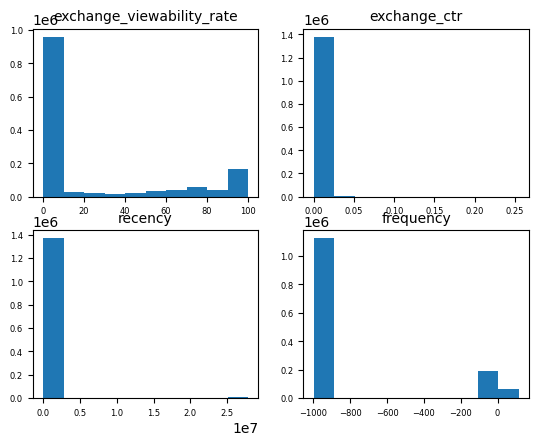

In [142]:
fig, axs = plt.subplots(2, 2)
for i,column in enumerate(['exchange_viewability_rate', 'exchange_ctr','recency', 'frequency']):
    axs[int(i/2),i%2].hist(df[column].to_numpy())
    axs[int(i/2),i%2].set_title(column,fontsize=10)
    axs[int(i/2),i%2].tick_params(axis='both', which='major', labelsize=6)
plt.plot()

In [146]:
for i,column in enumerate(['exchange_viewability_rate', 'exchange_ctr','recency', 'frequency']):
    print(df[column].describe())
for column in ['recency', 'frequency']:
    print( column, df[df[column]==-999].shape)

count    1.382862e+06
mean     2.202187e+01
std      3.596862e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.500000e+01
max      1.000000e+02
Name: exchange_viewability_rate, dtype: float64
count    1.382862e+06
mean     9.333455e-05
std      9.971006e-04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.543898e-01
Name: exchange_ctr, dtype: float64
count    1.382862e+06
mean     2.738455e+05
std      2.711994e+06
min     -9.990000e+02
25%     -9.990000e+02
50%     -9.990000e+02
75%     -9.990000e+02
max      2.783807e+07
Name: recency, dtype: float64
count    1.382862e+06
mean    -8.130922e+02
std      3.894093e+02
min     -9.990000e+02
25%     -9.990000e+02
50%     -9.990000e+02
75%     -9.990000e+02
max      1.140000e+02
Name: frequency, dtype: float64
recency (1126178, 51)
frequency (1126178, 51)


<AxesSubplot:>

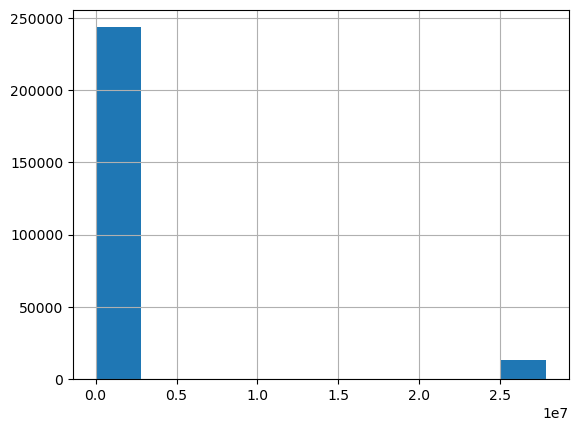

In [149]:
df[df["recency"]>-999]["recency"].hist()

In [151]:
df["recencyLog"]=df.apply(lambda x: np.log(x['recency']+1) if x["recency"]>-999 else -999,axis=1)

In [155]:
df[df["recencyLog"]>-999]["recencyLog"].mean()

10.362879541918057

In [156]:
for averageFill in ["recencyLog","frequency"]:
    avgval = df[df[averageFill]>-999][averageFill].mean()
    df[averageFill] = df.apply(lambda x: x[averageFill] if x[averageFill]>-999 else avgval, axis=1)

In [165]:
args.includeColumnsProposal1.remove('recency')

In [158]:
args.includeColumnsProposal1 = args.includeColumnsProposal1 + ["recencyLog"]

[]

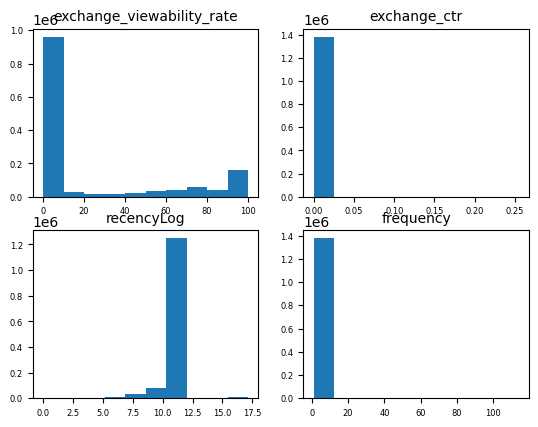

In [157]:
fig, axs = plt.subplots(2, 2)
for i,column in enumerate(['exchange_viewability_rate', 'exchange_ctr','recencyLog', 'frequency']):
    axs[int(i/2),i%2].hist(df[column].to_numpy())
    axs[int(i/2),i%2].set_title(column,fontsize=10)
    axs[int(i/2),i%2].tick_params(axis='both', which='major', labelsize=6)
plt.plot()

In [161]:
df['exchange_viewability_rate_log']=df.apply(lambda x: np.log(x['exchange_viewability_rate']+1), axis=1)
args.includeColumnsProposal1 .remove('exchange_viewability_rate')
args.includeColumnsProposal1 = args.includeColumnsProposal1 + ["exchange_viewability_rate_log"]

[]

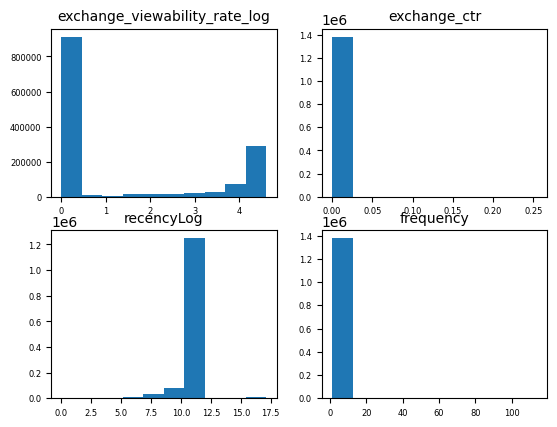

In [163]:
fig, axs = plt.subplots(2, 2)
for i,column in enumerate(['exchange_viewability_rate_log', 'exchange_ctr','recencyLog', 'frequency']):
    axs[int(i/2),i%2].hist(df[column].to_numpy())
    axs[int(i/2),i%2].set_title(column,fontsize=10)
    axs[int(i/2),i%2].tick_params(axis='both', which='major', labelsize=6)
plt.plot()

In [166]:
args.includeColumnsProposal1 

['exchange_ctr',
 'conversion_roi',
 'qualifiedPixel',
 'frequency',
 'device_model',
 'os_version',
 'browser_version',
 'browser_version_device_model',
 'hashed_app_id_device_model',
 'deal_id',
 'category_id',
 'dma_id',
 'browser_language_id',
 'region_id',
 'exchange_id',
 'isp_id',
 'impression_date',
 'size',
 'day_of_week',
 'creative_id',
 'id_vintage',
 'device_id',
 'device_type',
 'day_part',
 'conn_speed',
 'fold_position',
 'channel_type',
 'num_device_ids',
 'country_id',
 'cross_device_flag',
 'base_domain_device_model',
 'site_id_device_model',
 'publisher_id_device_model',
 'recencyLog',
 'exchange_viewability_rate_log']

In [170]:
df[args.includeColumnsProposal1+["Date"] ].to_csv("cleanData.csv",index=False)

[Text(0.5, 1.0, 'Dist(ROI)')]

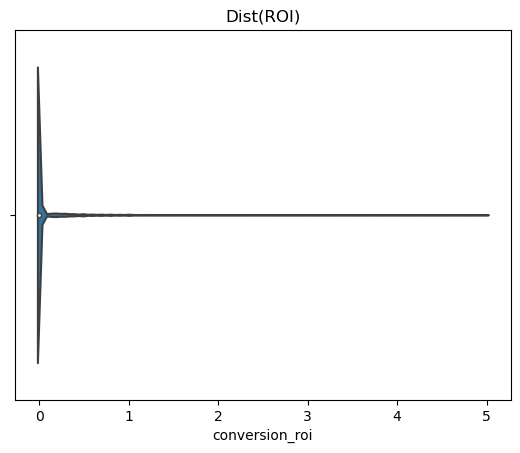

In [176]:
import seaborn as sns
sns.violinplot(x=df["conversion_roi"]).set(title='Dist(ROI)')

[Text(0.5, 1.0, 'Dist(ROI|ROI>0)')]

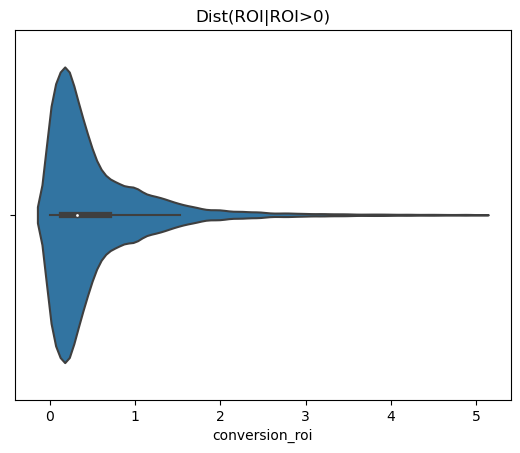

In [177]:
sns.violinplot(x=df[df["conversion_roi"]>0]["conversion_roi"]).set(title='Dist(ROI|ROI>0)')

In [178]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [187]:
features=df[df["conversion_roi"]>0]["conversion_roi"].to_numpy()
scaled_features=features.reshape(-1,1)

In [188]:
kmeans = KMeans(
init="random",
n_clusters=3,
n_init=10,
max_iter=300,
random_state=42)
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

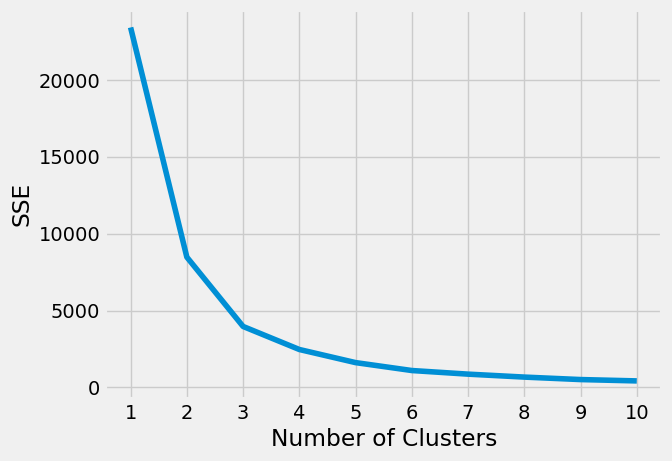

In [189]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": 42,
}

 # A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [190]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

3

In [191]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

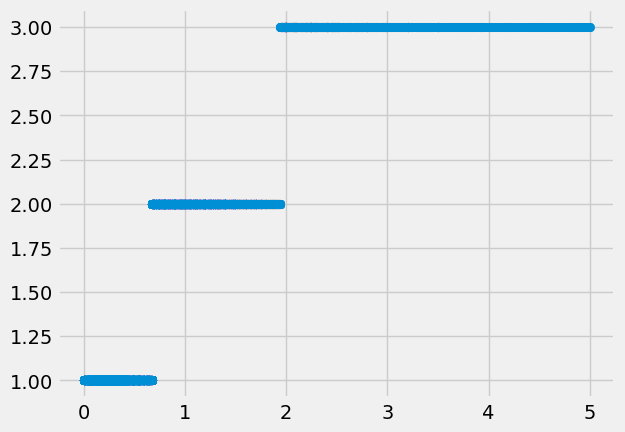

In [192]:
plt.scatter(scaled_features,kmeans.labels_*-1+3)
plt.show()

In [193]:
results =[]
for cluster in range(3):
    results.append(scaled_features[kmeans.labels_==cluster])
for i,result in enumerate(results):
    print("Cluster {}, max={:0.3f}, min={:0.3f}, avg={:0.3f}, counts = {}".format(3-i,np.max(result), np.min(result), np.average(result),result.shape[0]))
    

Cluster 3, max=4.999, min=1.942, avg=2.779, counts = 2336
Cluster 2, max=1.941, min=0.677, avg=1.109, counts = 12635
Cluster 1, max=0.676, min=0.000, avg=0.245, counts = 41697
